### CIFAR10 Classifation - With and Without Data Augmentation

In [1]:
## import neccessary libraries to build a model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

In [3]:
#Device configuration

device=torch.device("mps" if torch.backends.mps.is_available() else "gpu" if torch.cuda.is_available() else "cpu")
device

device(type='mps')

In [4]:
#Transformation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))]
                              )
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [5]:
#CIFAR dataset

train_dataset= torchvision.datasets.CIFAR10(
    root="data",
    download=False,
    train=True,
    transform=transform)

test_dataset=torchvision.datasets.CIFAR10(
    root="data",
    download=False,
    train=False,
    transform=transform)
#here we mentioned download = false beacuse alread data has been downloaded and root is path needs to be mentioned
#train = True,train dataset and transformed the data to -1 to 1(normalized)

In [6]:
# size of the datasets

len(train_dataset),len(test_dataset)

(50000, 10000)

In [7]:
#Data loader

train_loader= DataLoader(train_dataset,shuffle=True,batch_size=64)
test_loader=DataLoader(test_dataset,shuffle=True,batch_size=64)


In [8]:
# visualization

for i,(images,labels) in enumerate(train_loader):
    print(images.size())
    print(labels.size())
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


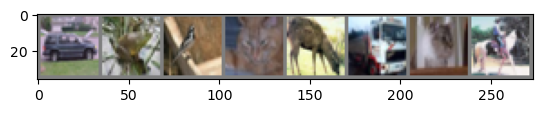

In [9]:
def imshow(img):
    img=img/2+0.5
    img=img.numpy()#converting back to numpy
    plt.imshow(np.transpose(img,(1,2,0)))#here numpy accepts height,width, and channel format
    plt.show()


imshow(torchvision.utils.make_grid(images[:8]))

In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

[classes[i] for i in labels[:8]]

['car', 'frog', 'bird', 'cat', 'deer', 'truck', 'cat', 'horse']

### Train a nmodel

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,padding="same",kernel_size=(3,3)),#output will be 32*32*32>c*h*w
            nn.ReLU(),
            nn.MaxPool2d(stride=(2,2),kernel_size=(2,2)),
            nn.Conv2d(32,64,padding="same",kernel_size=(3,3)),#output will be 64*16*16>c*h*w
            nn.ReLU(),
            nn.MaxPool2d(stride=(2,2),kernel_size=(2,2))#output will be 64*8*8
        )
        self.fc_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8,600),
            nn.ReLU(),
            nn.Linear(600,120),
            nn.ReLU(),
            nn.Linear(120,10)
        )
        
        
    def forward(self,x):
        x=self.features(x)
        x=self.fc_layer(x)
        return x


        

In [13]:
model=CNN()
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=600, bias=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=120, bias=True)
    (4): ReLU()
    (5): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [14]:
# loss function and optimizer

criterion = nn.CrossEntropyLoss()#beacuse we have 1 output classes
optimizer = optim.Adam(model.parameters(),lr=0.001)


In [15]:
def train_model(model,train_loader,test_loader,criterion,optimizer,epochs=5):
    train_losses,test_losses,accuracy=[],[],[]
    for epoch in range(epochs):
        model.train()
        running_loss=0
        for images,labels in train_loader:
            output=model(images)
            loss=criterion(output,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        train_losses.append(running_loss/len(train_loader))


        #model eval
        val_losses=0
        with torch.no_grad():
            correct=0
            total=0
            for images,labels in test_loader:
                outputs=model(images)
                loss=criterion(outputs,labels)
                _,predicted=torch.max(outputs.data,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
                val_losses+=loss.item()
        test_losses.append(val_losses/len(test_loader))
        accuracy.append(correct*100/total)

        print(f" epoch [{epoch+1}/{epochs}] train loss: {train_losses[-1]:.2f} and test_loss :{test_losses[-1]:.2f}")
    return train_losses,test_losses,accuracy
                           
                

In [16]:
trainn_loss_without_aug,test_losses_without_aug,accuracy_without_aug=train_model(model,train_loader,test_loader,criterion,optimizer,epochs=5)

 epoch [1/5] train loss: 1.32 and test_loss :1.04
 epoch [2/5] train loss: 0.92 and test_loss :0.88
 epoch [3/5] train loss: 0.72 and test_loss :0.81
 epoch [4/5] train loss: 0.54 and test_loss :0.81
 epoch [5/5] train loss: 0.38 and test_loss :0.90


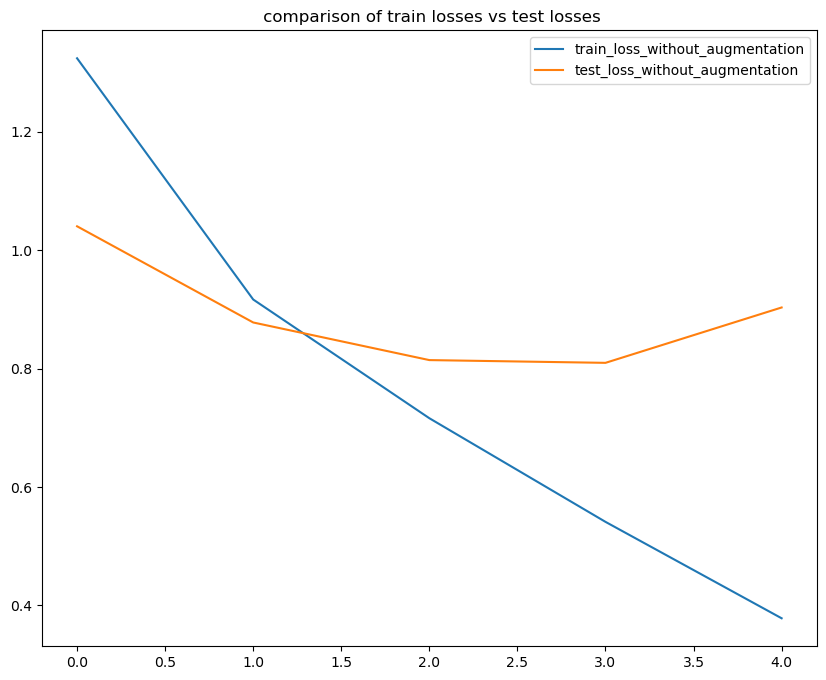

In [17]:
#visualisation

plt.figure(figsize=(10,8))
plt.plot(trainn_loss_without_aug,label="train_loss_without_augmentation")
plt.plot(test_losses_without_aug,label="test_loss_without_augmentation")
plt.title(f" comparison of train losses vs test losses")
plt.legend()
plt.show()

#### with data agumentation

In [19]:
transform_with_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [20]:
train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_with_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)


In [23]:
model_aug = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

train_losses, val_losses, val_accuracy = train_model(model_aug,train_loader,test_loader,criterion,optimizer,epochs=5)

 epoch [1/5] train loss: 1.34 and test_loss :1.06
 epoch [2/5] train loss: 0.91 and test_loss :0.93
 epoch [3/5] train loss: 0.72 and test_loss :0.84
 epoch [4/5] train loss: 0.54 and test_loss :0.82
 epoch [5/5] train loss: 0.38 and test_loss :0.86


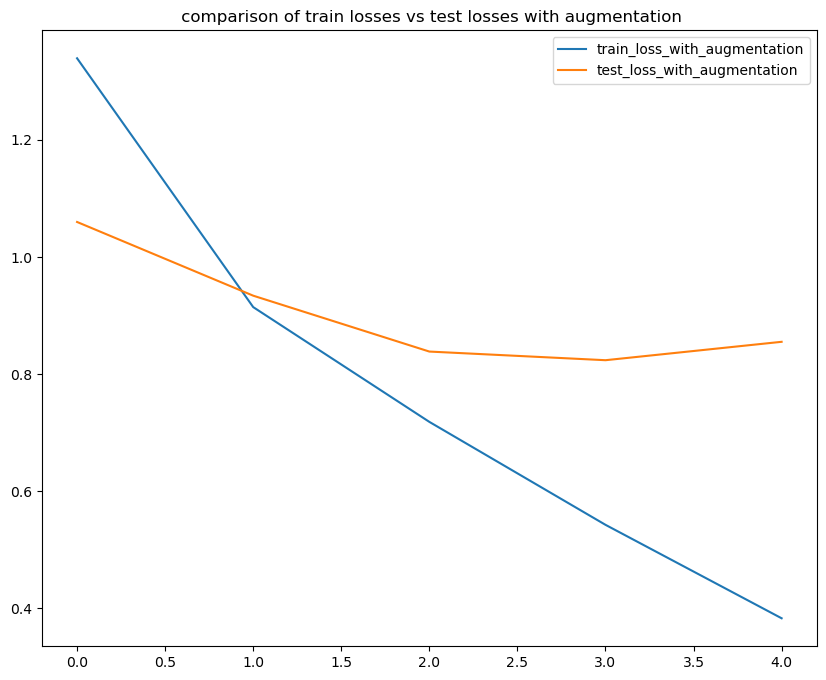

In [25]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,label="train_loss_with_augmentation")
plt.plot(val_losses,label="test_loss_with_augmentation")
plt.title(f" comparison of train losses vs test losses with augmentation")
plt.legend()
plt.show()